In [3]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from vis_common import load_store, load_games

from crawl_data import CANON_SPECIES, CANON_BGS

f = load_games()
print "Loaded data frame with {} records and {} columns".format(
    len(f), len(f.columns))

FS = (10, 6) # Reasonable default figsize

Loaded data frame with 1326162 records and 28 columns


Rune questions:
- most popular first/second/third/fourth rune
- relationship btween rune order and chance of winning/player winrate
- does species/bg affect choice of third rune?
- at what XL do players get 1st/2nd/3rd rune? (XXX data not available)

In [2]:
s = load_store()
r = s['runes']

In [3]:
print r.columns
print len(r)
r.head()

Index([u'gid', u'order', u'rune', u'xl'], dtype='object')
125633


,gid,order,rune,xl
0,94,1,gossamer,18
1,94,2,barnacled,19
2,240,1,gossamer,18
3,240,2,barnacled,21
4,259,1,serpentine,17


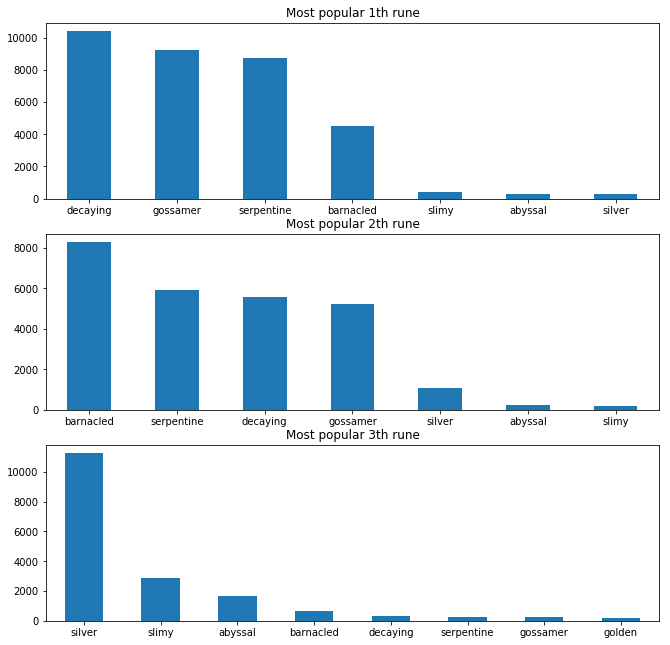

In [4]:
thresh = 50
fig, axes = plt.subplots(nrows=3, figsize=(11,11))
for nth, ax in zip(range(1,4), axes.flatten()):
    r[r['order']==nth].groupby('rune').size().where(lambda x: x > thresh).dropna()\
        .sort_values(ascending=0).plot.bar(ax=ax, title="Most popular {}th rune".format(nth));
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("")

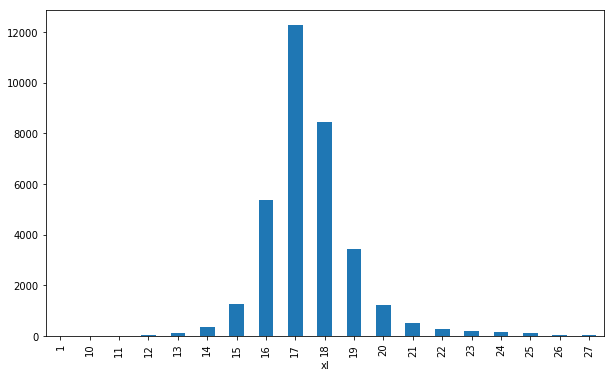

In [5]:
r[r['order']==1].groupby('xl').size().plot.bar(figsize=FS);

In [ ]:
# TODO: Helper functions to get some pid splits based on winning/nonwinning, or 
# winrate quantiles subject to some minimum number of games.
# Then also a helper to, like, do two versions of a graph, split by those pids


In [16]:
r['won'] = r['gid'].isin(f[f['won']].index)

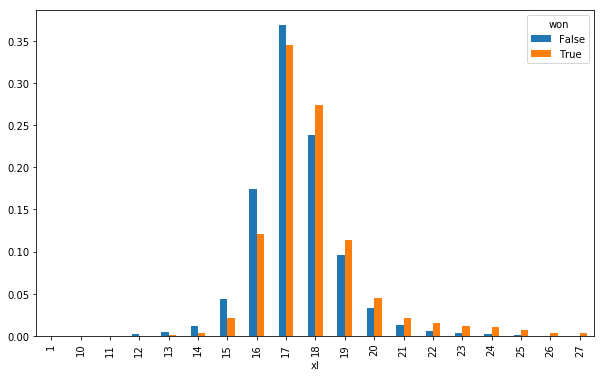

In [30]:
foo = r[r['order']==1].groupby(['xl', 'won']).size()
foo = foo.reset_index(level=1).pivot(columns='won', values=0)
foo[False] /= foo[False].sum()
foo[True] /= foo[True].sum()
foo.plot.bar(figsize=FS, title="Player level when getting first rune");

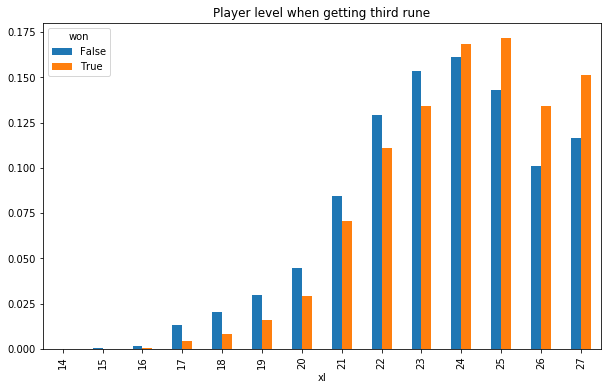

In [31]:
foo = r[r['order']==3].groupby(['xl', 'won']).size()
foo = foo.reset_index(level=1).pivot(columns='won', values=0)
foo[False] /= foo[False].sum()
foo[True] /= foo[True].sum()
foo.plot.bar(figsize=FS, title="Player level when getting third rune");

In [7]:
f[f['nrunes'] > 0].groupby(['wheredied', 'depth']).size().sort_values(ascending=0).head(10)

wheredied      depth
vaults         5.0      2107
elven halls    3.0      1262
realm of zot   5.0      1060
vaults         2.0       776
depths         2.0       763
vaults         4.0       761
               1.0       734
abyss          1.0       727
pits of slime  6.0       721
vaults         3.0       654
dtype: int64

In [18]:
rpp = f.groupby('pid')['nrunes'].sum()
rpp.describe([.75, .8, .85, .9, .95])

count    26004.000000
mean         4.773881
std         30.771301
min          0.000000
50%          0.000000
75%          0.000000
80%          0.000000
85%          1.000000
90%          5.000000
95%         18.000000
max       1222.000000
Name: nrunes, dtype: float64

In [20]:
foo = f[f['pid'].isin(gpp[gpp >= 10].index)].groupby('pid')['nrunes'].sum()
foo.describe([.1, .25, .5, .6, .7, .75, .8, .85, .9])

count    8749.000000
mean       13.873928
std        51.832415
min         0.000000
10%         0.000000
25%         0.000000
50%         0.000000
60%         1.000000
70%         4.000000
75%         6.000000
80%        11.000000
85%        18.000000
90%        32.000000
max      1222.000000
Name: nrunes, dtype: float64

In [15]:
gpp = games_per_pid = f.groupby('pid').size()
foo = f[f['pid'].isin(gpp[gpp >= 10].index)].groupby('pid')['won'].mean()
(foo * 100).describe([.1, .25, .5, .75, .8, .85, .9])

count    8749.000000
mean        0.790670
std         3.441129
min         0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
80%         0.219877
85%         0.776570
90%         1.787316
max        72.289157
Name: won, dtype: float64

In [8]:
wpp = wins_per_pid = f.groupby('pid')['won'].sum()
winpids = wpp.where(lambda wins: wins > 0).dropna().index
iwinner = f['pid'].isin(winpids)

In [12]:
wrpp = winrate_per_pid = f.groupby('pid')['won'].mean()
print "Distribution of non-zero win %s among players"
(100*wrpp[wrpp > 0]).describe([.1, .25, .5, .75, .9])

Distribution of non-zero win %s among players


count    2111.000000
mean        7.456383
std        16.148960
min         0.012240
10%         0.310078
25%         0.699301
50%         1.886792
75%         5.882353
90%        19.298246
max       100.000000
Name: won, dtype: float64

In [13]:
mingames = 10
gpp = f.groupby('pid').size()
minpids = gpp[gpp >= mingames].index
wrpp = winrate_per_pid = f[f['pid'].isin(minpids)].groupby('pid')['won'].mean()
print "Distribution of non-zero win %s among players with at least 10 games"
(100*wrpp[wrpp > 0]).describe([.1, .25, .5, .75, .9])

Distribution of non-zero win %s among players with at least 10 games


count    1895.000000
mean        3.650432
std         6.651917
min         0.012240
10%         0.274725
25%         0.633580
50%         1.612903
75%         3.703704
90%         8.333333
max        72.289157
Name: won, dtype: float64

In [14]:
wrpp.quantile(.9)

0.14788553259141562

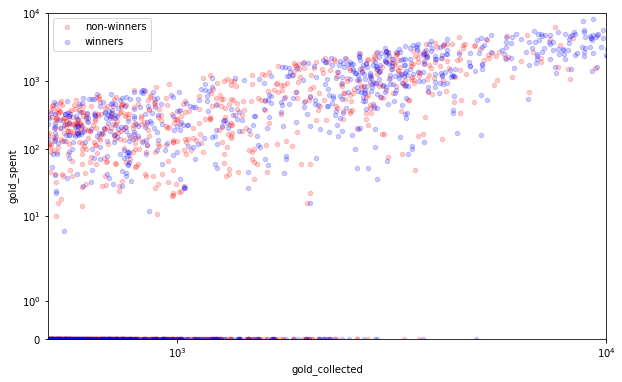

In [29]:
n = 1000
collected_thresh = 500
iwealthy = f['gold_collected'] >= collected_thresh
ax = f[iwealthy & ~iwinner].head(n)[['gold_collected', 'gold_spent']]\
    .plot.scatter(x='gold_collected', y='gold_spent', figsize=FS, alpha=.2,
                 label='non-winners', color='red'
                 );
f[iwealthy & iwinner].head(n)[['gold_collected', 'gold_spent']]\
    .plot.scatter(x='gold_collected', y='gold_spent', figsize=FS, alpha=.2,
                  label='winners', color='blue', ax=ax,
                 );
ax.set_xlim(collected_thresh, 10000);
ax.set_ylim(0, 10000);
ax.set_xscale('symlog');
ax.set_yscale('symlog');

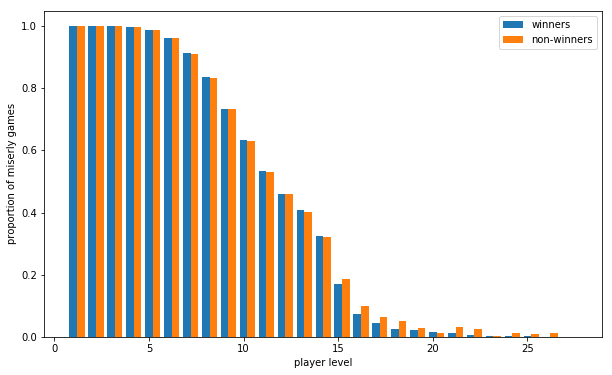

In [38]:
w = .4
fig, ax = plt.subplots(figsize=FS)
misers_per_level = f[iwinner & (f['gold_spent']==0)].groupby('level').size()
normed = (misers_per_level / f[iwinner].groupby('level').size())
ax.bar(normed.index, normed.values, w, label='winners');

misers_per_level = f[~iwinner & (f['gold_spent']==0)].groupby('level').size()
normed = (misers_per_level / f[~iwinner].groupby('level').size())
ax.bar(normed.index.astype(int)+w, normed.values, w, label='non-winners');
ax.legend();
ax.set_xlabel('player level')
ax.set_ylabel('proportion of miserly games');
# TODO: repeat comparison using winrate percentiles

Series([], dtype: int64)

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Below this is a graveyard of pretty old code which may or may not run now.
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [3]:
# print "Went from {} games to {} after filtering out games with \
# experimental species/bgs, instantly-quit games, and games by bots".format(len(fr), len(f))

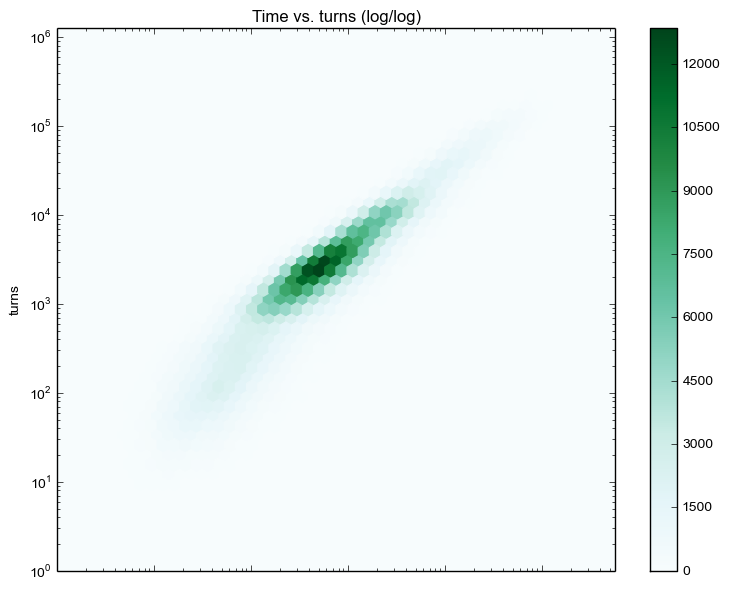

In [18]:
f.loc[ (f['time'] > 0) & (f['turns'] > 0)].plot.hexbin(x='time', y='turns', 
                                                    gridsize=50, 
                                                    xscale='log', yscale='log',
                                                    figsize=(9,7),
                                                    title='Time vs. turns (log/log)'
                                                   );

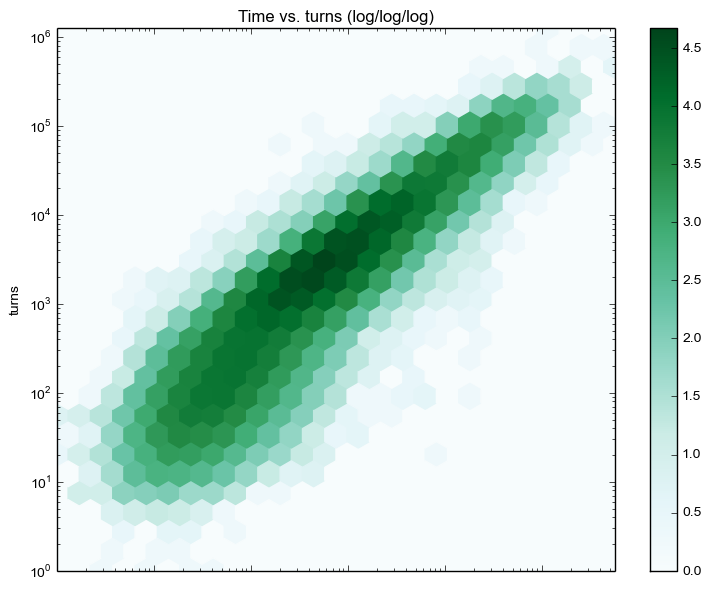

In [16]:
f.loc[ (f['time'] > 0) & (f['turns'] > 0)].plot.hexbin(x='time', y='turns', 
                                                    gridsize=25, 
                                                    bins='log',
                                                    xscale='log', yscale='log',
                                                    figsize=(9,7),
                                                    title='Time vs. turns (log/log/log)'
                                                   );

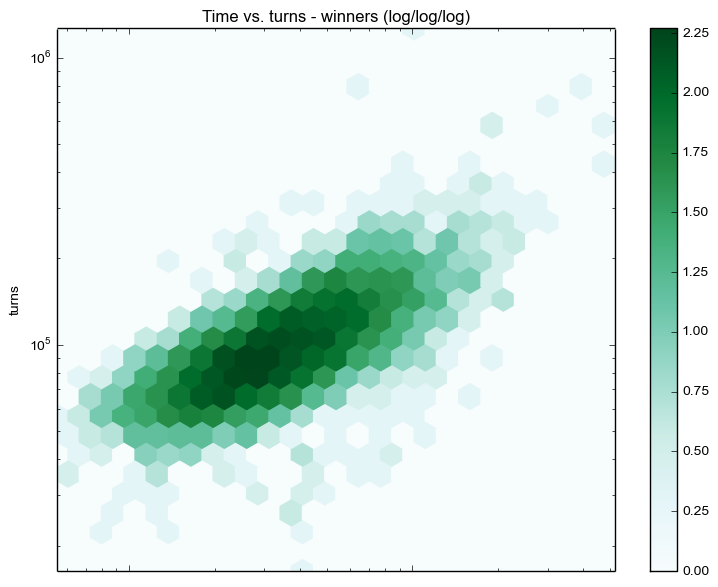

In [15]:
f.loc[ (f['time'] > 0) & (f['turns'] > 0) & iwon ].plot.hexbin(x='time', y='turns', 
                                                    gridsize=25, 
                                                    bins='log',
                                                    xscale='log', yscale='log',
                                                    figsize=(9,7),
                                                    title='Time vs. turns - winners (log/log/log)'
                                                   );

In [19]:
fr = load_frame(raw=True)
bots = fr[fr['bot'] == True]
del fr # Blurgh, this doesn't seem to effectively release the memory.

In [29]:
n = len(bots)
n

1190

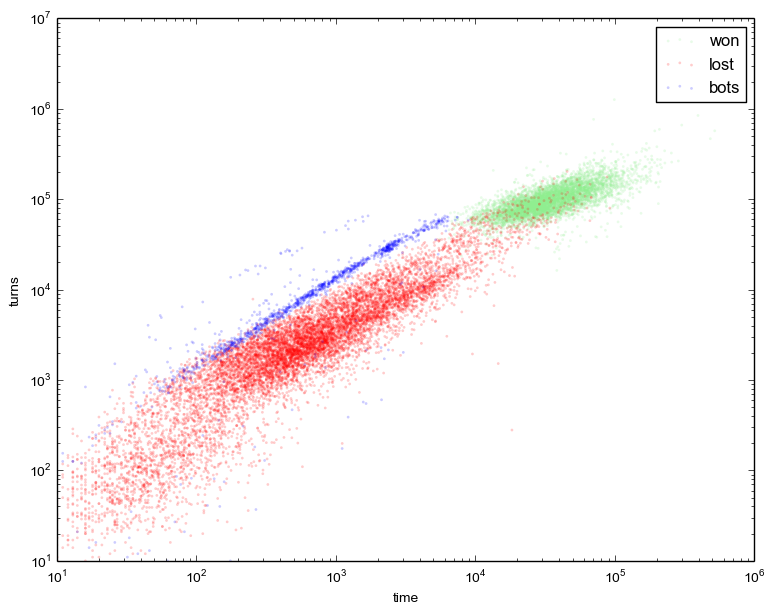

In [41]:
s = 4
alpha = 0.2
ax = f.loc[iwon].head(n).plot.scatter(x='time', y='turns', color='lightgreen', label='won',
                         #xscale='log', yscale='log',
                                    loglog=1,
                            figsize=(9,7), alpha=alpha, s=s, lw=0)
ax.set_xlim(left=10)
ax.set_ylim(bottom=10)
f.loc[ilost].head(n).plot.scatter(x='time', y='turns', color='red', label='lost', ax=ax, alpha=alpha, s=s, lw=0);
bots.plot.scatter(x='time', y='turns', color='blue', label='bots', 
                  ax=ax, alpha=alpha, s=s, lw=0);

if 0:
    l, r = 10, 10**6
    b, t = 10, 10**7
    ax.set_xlim(l, r)
    ax.set_ylim(b, t)
    ax.plot(
        [l, r],
        [l, r],
        #label='One turn per second',
        color='black', lw=lw,
    )
    ax.plot(
        [l, t/2],
        [l*2, t],
        #label='Two turns per second',
        color='black', lw=lw,
    )
    ax.plot(
        [l, t/4],
        [l*4, t],
        #label='Two turns per second',
        color='black', lw=lw,
    )
    ax.plot(
        [l, t/8],
        [l*8, t],
        #label='Two turns per second',
        color='black', lw=lw,
    )

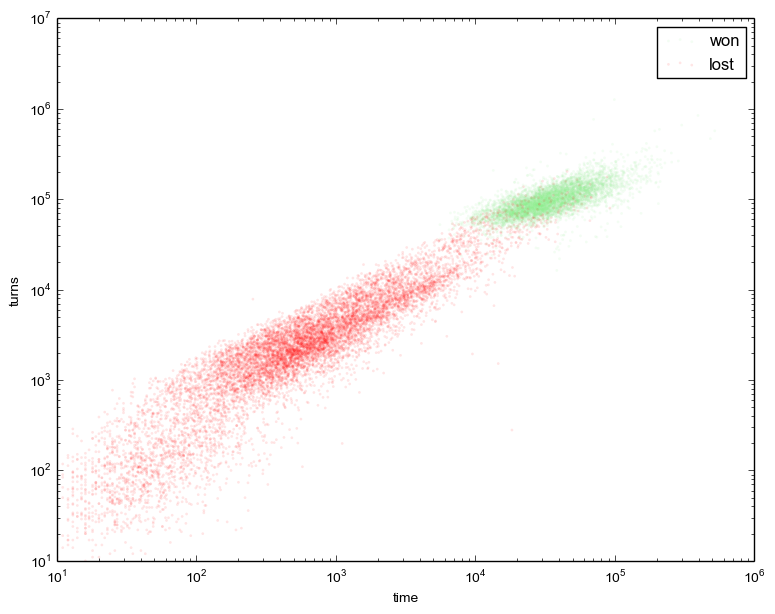

In [43]:
s = 4
alpha = 0.1
n = 10000
ax = f.loc[iwon].head(n).plot.scatter(x='time', y='turns', color='lightgreen', label='won',
                         #xscale='log', yscale='log', # this doesn't work for some reason
                                    loglog=1,
                            figsize=(9,7), alpha=alpha, s=s, lw=0)
ax.set_xlim(left=10)
ax.set_ylim(bottom=10)
f.loc[ilost].head(n).plot.scatter(x='time', y='turns', color='red', label='lost', ax=ax, alpha=alpha, s=s, lw=0);
#f[f['howdied']=='quit'].head(1000).plot.scatter(x='time', y='turns', color='blue', label='quit', ax=ax, alpha=1, s=s, lw=0);

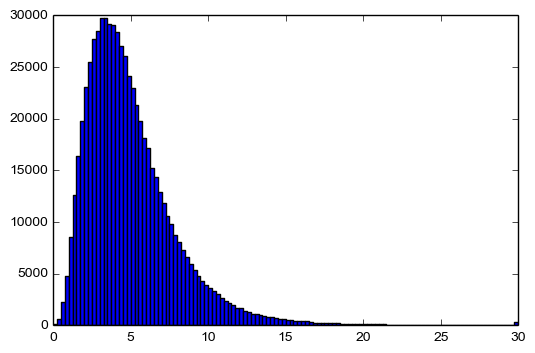

In [6]:
turns_per_sec = (f[f['level'] > 1]['turns'] / f[f['level'] > 1]['time'])
bins = list(np.arange(0, 30, .25)) + [200]
counts, _ = np.histogram(turns_per_sec, bins)
plt.bar(bins[:-1], counts, width=.25);
# Turns taken per second

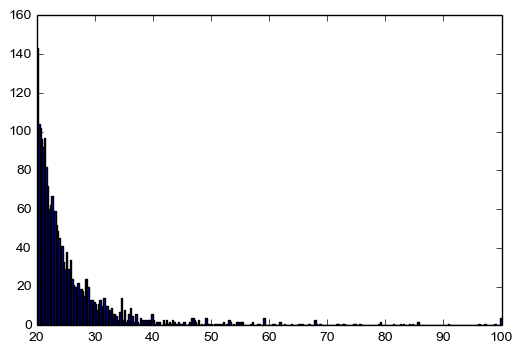

In [9]:
turns_per_sec = (f[f['level'] > 1]['turns'] / f[f['level'] > 1]['time'])
bins = list(np.arange(20, 100, .25)) + [200]
counts, _ = np.histogram(turns_per_sec, bins)
plt.bar(bins[:-1], counts, width=.25);
# Turns taken per second

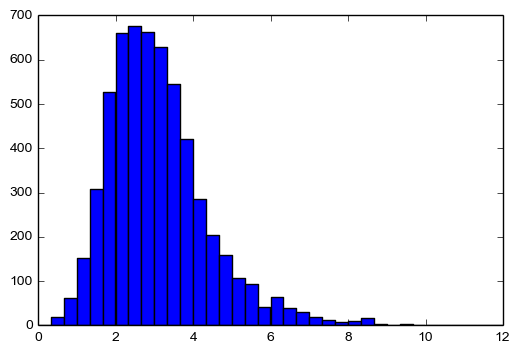

In [44]:
turns_per_sec = (f.loc[iwon]['turns'] / f.loc[iwon]['time'])
bins = list(np.arange(0, 12, 1/3.0)) + [200]
counts, _ = np.histogram(turns_per_sec, bins)
plt.bar(bins[:-1], counts, width=.33);
# Turns per second among winners

16


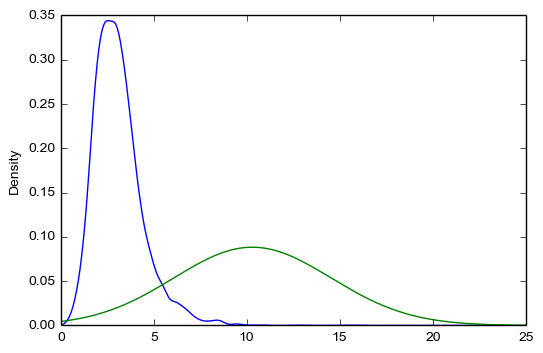

In [49]:
# TODO: I wish there was a way to manually set the bandwidth :(
ax = turns_per_sec.plot.kde(xlim=(0,25), label='humans')

winbots = bots[bots['won'] == True]
print len(winbots)
# Okay, well sample size here is pretty small
# Which is actually kinda surprising. 16 wins out of 1190 games? I thought qw was supposed
# to have like a 10% win rate?
bot_turns_per_sec = (winbots['turns'] / winbots['time'])
bot_turns_per_sec.plot.kde(ax=ax, label='bots')